# CS 171 Final Project — TACO Model
### Waste Sorting with Classical ML + CNNs
**Authors:** Lwin Moe  
**Update Date:** Dec 4, 2025

This notebook shows the training and evluation process, focusing on the TACO dataset (waste images "in the wild"). The goal is to create a clean classification subset mapped to the TrashNet classes (cardboard, glass, metal, paper, plastic, trash).


## Project Goal (Short Summary)
Our project explores how well supervised learning models can classify common waste types.


# **Part 1 - Organizing the Data**

In this part of the project, we load and organize our dataset for deep learning.  
The prepared dataset from CS171_TACO_DataPreparation file is provided in three CSV files:

- train.csv
- val.csv
- test.csv

Each CSV contains two columns:

- **filepath** — relative path to an image file  
- **label** — the class name

Each image has dimensions of 200×200.

Example:
| filepath | label |
|---|---|
| TACO_clean/Cigarette/000086.JPG | Cigarette |
| TACO_clean/Cigarette/000087.JPG | Cigarette |


Because the dataset is not stored in class-organized folders, we create a **custom PyTorch Dataset** that reads filepaths and labels directly from the CSV files.



### **Libraries**

In [10]:
import os
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


### **Read the Data**

In [11]:
train_df = pd.read_csv("splits/train.csv")
val_df   = pd.read_csv("splits/val.csv")
test_df  = pd.read_csv("splits/test.csv")

print("Training samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Training samples: 1475
Validation samples: 308
Test samples: 308


### **Class for Dataset**

In [12]:
class CSVDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = sorted(df['label'].unique())
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        img = Image.open(img_path).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
        
        label = self.class_to_idx[row["label"]]
        return img, label


### **Transforms and DataLoaders**

In [13]:
# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
])

# Validation/test transforms
eval_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

train_dataset = CSVDataset(train_df, transform=train_transforms)
val_dataset   = CSVDataset(val_df, transform=eval_transforms)
test_dataset  = CSVDataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

len(train_loader), len(val_loader), len(test_loader)


(47, 10, 10)

# **Part 2: Constructing the CNN Model**

Here we define the model architecture.  
We choose **ResNet18**, a widely-used convolutional neural network with ~11M parameters and strong baseline performance.

We replace its final fully-connected layer to match the number of classes in our dataset.

In [14]:
# Load pretrained ResNet18 properly across different versions of torchvision
try:
    model = models.resnet18(weights="IMAGENET1K_V1")
except:
    model = models.resnet18(pretrained=True)

# Replace final fully-connected layer for our dataset
num_classes = len(train_dataset.classes)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

# Freeze all layers except the final fc (Phase 1)
for name, param in model.named_parameters():
    if "fc" not in name:
        param.requires_grad = False

print("Model ready.")

Model ready.


# **Part 3 Training the Model**

We train the CNN and track:
- Training loss
- Validation loss
- Training accuracy
- Validation accuracy
We will also store the best model weights using early stopping.

### **Phase 1: Train only the final layer**

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4)  # train only the classifier

def train_one_epoch(model, loader):
    model.train()
    total_loss, total_correct = 0, 0
    
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
        total_correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, total_correct = 0, 0
    
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            total_correct += (outputs.argmax(1) == labels).sum().item()
    
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)


### **Running Phase 1**

In [16]:
epochs = 30
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("PHASE 1: Training only the final fully-connected layer...\n")

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


PHASE 1: Training only the final fully-connected layer...

Epoch 1/30
  Train Loss: 3.9247 | Train Acc: 0.0475
  Val   Loss: 4.5978 | Val   Acc: 0.0000
Epoch 2/30
  Train Loss: 3.6767 | Train Acc: 0.0556
  Val   Loss: 4.7507 | Val   Acc: 0.0032
Epoch 3/30
  Train Loss: 3.6354 | Train Acc: 0.0597
  Val   Loss: 4.7964 | Val   Acc: 0.0032
Epoch 4/30
  Train Loss: 3.6079 | Train Acc: 0.0698
  Val   Loss: 4.8175 | Val   Acc: 0.0032
Epoch 5/30
  Train Loss: 3.5837 | Train Acc: 0.0705
  Val   Loss: 4.8588 | Val   Acc: 0.0032
Epoch 6/30
  Train Loss: 3.5580 | Train Acc: 0.0712
  Val   Loss: 4.8714 | Val   Acc: 0.0065
Epoch 7/30
  Train Loss: 3.5439 | Train Acc: 0.0739
  Val   Loss: 4.9029 | Val   Acc: 0.0032
Epoch 8/30
  Train Loss: 3.5064 | Train Acc: 0.0861
  Val   Loss: 4.8988 | Val   Acc: 0.0032
Epoch 9/30
  Train Loss: 3.4993 | Train Acc: 0.0766
  Val   Loss: 4.9014 | Val   Acc: 0.0032
Epoch 10/30
  Train Loss: 3.4792 | Train Acc: 0.0739
  Val   Loss: 4.9063 | Val   Acc: 0.0065
Epoch 11/3

### **Phase 2: Fine Tuning Entire Net**

In [17]:
# Unfreeze entire ResNet18 backbone
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5)

print("PHASE 2: Fine-tuning entire ResNet18...\n")

epochs = 7  # fine-tuning usually needs fewer epochs

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")


PHASE 2: Fine-tuning entire ResNet18...

Epoch 1/7
  Train Loss: 3.1344 | Train Acc: 0.1573
  Val   Loss: 5.0158 | Val   Acc: 0.0032
Epoch 2/7
  Train Loss: 3.0588 | Train Acc: 0.1729
  Val   Loss: 5.0277 | Val   Acc: 0.0032
Epoch 3/7
  Train Loss: 3.0073 | Train Acc: 0.1783
  Val   Loss: 5.0518 | Val   Acc: 0.0032
Epoch 4/7
  Train Loss: 2.9581 | Train Acc: 0.1986
  Val   Loss: 5.0878 | Val   Acc: 0.0032
Epoch 5/7
  Train Loss: 2.8933 | Train Acc: 0.2163
  Val   Loss: 5.1149 | Val   Acc: 0.0032
Epoch 6/7
  Train Loss: 2.8660 | Train Acc: 0.2380
  Val   Loss: 5.1030 | Val   Acc: 0.0032
Epoch 7/7
  Train Loss: 2.8158 | Train Acc: 0.2359
  Val   Loss: 5.1126 | Val   Acc: 0.0032


### **Plotting Loss and Accuracy Curves**

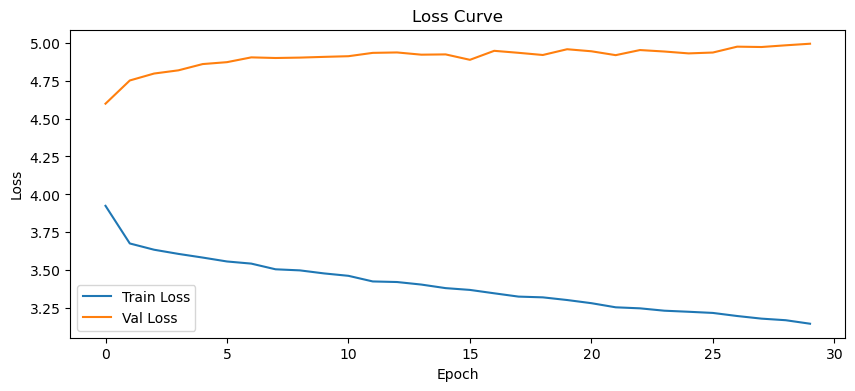

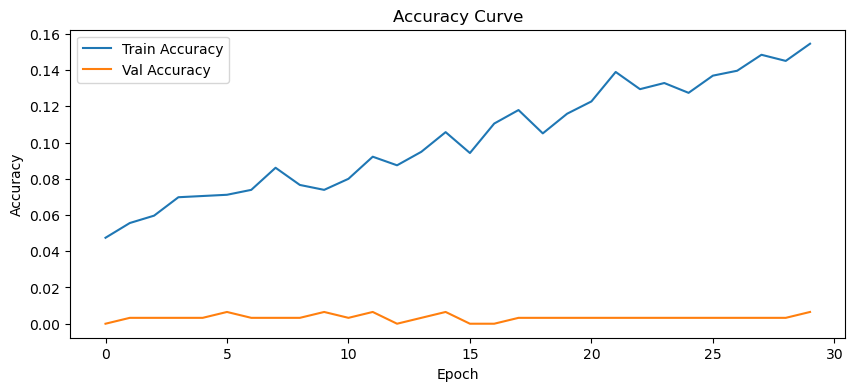

In [18]:
plt.figure(figsize=(10,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.show()

### **Final Test Accuracy**

We are testing the model on unseen data.

In [19]:
test_loss, test_acc = evaluate(model, test_loader)
print(f"Final Test Accuracy: {test_acc:.4f}")


Final Test Accuracy: 0.0195


IndexError: list index out of range

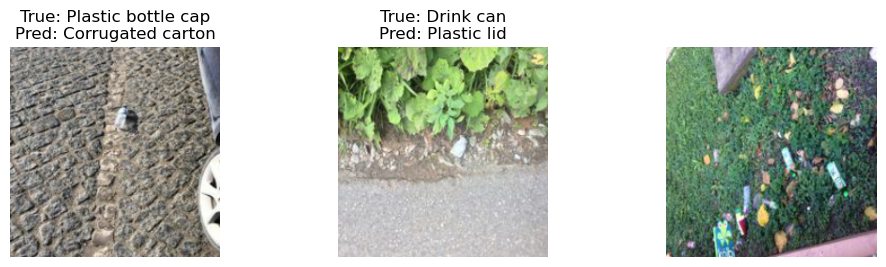

In [20]:
model.eval()
idxs = random.sample(range(len(test_dataset)), 6)

plt.figure(figsize=(12,6))
for i, idx in enumerate(idxs):
    img, label = test_dataset[idx]
    with torch.no_grad():
        output = model(img.unsqueeze(0).to(device))
        pred = output.argmax(1).item()
    
    img_np = img.permute(1,2,0).numpy()
    
    plt.subplot(2,3,i+1)
    plt.imshow(img_np)
    plt.axis("off")
    plt.title(f"True: {test_dataset.classes[label]}\nPred: {test_dataset.classes[pred]}")
plt.show()
